Régression

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
data = pd.read_csv("data/prices.csv") 
data.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [9]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
None
                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000       0.880000   
25%        33.840000      33.849998      33.480000      34.189999   
50%        52.770000      52.799999      52.230000      53.310001   
75%    

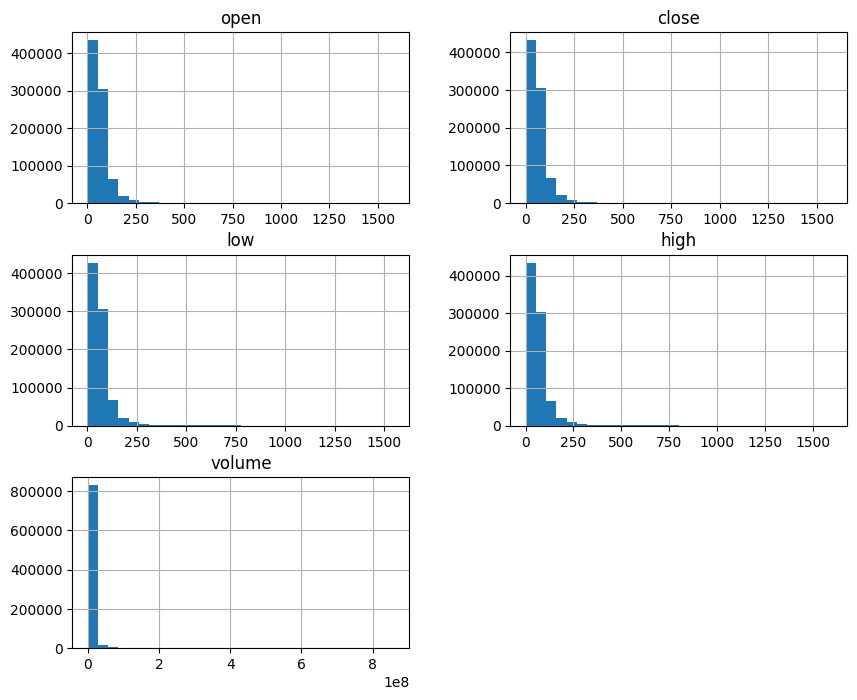

In [10]:
data.hist(bins=30, figsize=(10, 8))
plt.show()

In [16]:
print(data.dtypes)

date       object
symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object


In [17]:
data = pd.get_dummies(data, columns=['symbol'], drop_first=True)

In [18]:
print(data.dtypes)

date            object
open           float64
close          float64
low            float64
high           float64
                ...   
symbol_YHOO       bool
symbol_YUM        bool
symbol_ZBH        bool
symbol_ZION       bool
symbol_ZTS        bool
Length: 506, dtype: object


In [19]:
X = data.drop(columns=['close', 'date'])
y = data['close']

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [22]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [23]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

input_dim = X_train.shape[1]
model = RegressionModel(input_dim)


In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [40]:
# Entraînement du modèle
num_epochs = 100
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')


Epoch [10/100], Loss: 3.3223, Test Loss: 3.3455
Epoch [20/100], Loss: 3.2820, Test Loss: 3.3042
Epoch [30/100], Loss: 3.2406, Test Loss: 3.2653
Epoch [40/100], Loss: 3.1929, Test Loss: 3.2214
Epoch [50/100], Loss: 3.1616, Test Loss: 3.1882
Epoch [60/100], Loss: 3.1205, Test Loss: 3.1483
Epoch [70/100], Loss: 3.0760, Test Loss: 3.1044
Epoch [80/100], Loss: 3.0254, Test Loss: 3.0511
Epoch [90/100], Loss: 2.9841, Test Loss: 3.0163
Epoch [100/100], Loss: 2.9474, Test Loss: 2.9807


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = {
    'hidden_layer_sizes': [(4, 2)],
    'learning_rate_init': [0.01, 0.1],
    'max_iter': [200, 500, 1000] 
}

mlp = MLPRegressor(verbose=True)  

grid_search = GridSearchCV(mlp, param_grid, cv=2)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
print("Final loss after training:", best_model.loss_)
print("Number of iterations:", best_model.n_iter_)

if best_model.n_iter_ < best_model.max_iter:
    print("Le modèle a convergé avant la limite d'itérations.")
else:
    print("Le modèle n'a pas convergé dans la limite des itérations. Augmentez 'max_iter' si nécessaire.")


Iteration 1, loss = 5567.88057226
Iteration 2, loss = 4701.33227628
Iteration 3, loss = 4112.33560515
Iteration 4, loss = 3751.89604129
Iteration 5, loss = 3575.61371464
Iteration 6, loss = 3521.40436538
Iteration 7, loss = 3514.34976203
Iteration 8, loss = 3514.07412556
Iteration 9, loss = 3514.07463562
Iteration 10, loss = 3514.07277437
Iteration 11, loss = 3514.08099136
Iteration 12, loss = 3514.07258428
Iteration 13, loss = 3514.07696721
Iteration 14, loss = 3514.07600700
Iteration 15, loss = 3514.07866772
Iteration 16, loss = 3514.07679686
Iteration 17, loss = 3514.06958369
Iteration 18, loss = 3514.07481612
Iteration 19, loss = 3514.07856350
Iteration 20, loss = 3514.07853162
Iteration 21, loss = 3514.07252781
Iteration 22, loss = 3514.08236346
Iteration 23, loss = 3514.08277735
Iteration 24, loss = 3514.08019623
Iteration 25, loss = 3514.07938664
Iteration 26, loss = 3514.04751562
Iteration 27, loss = 3514.08235229
Iteration 28, loss = 3514.08483690
Iteration 29, loss = 3514.083

C:\Users\zakar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")

KeyboardInterrupt



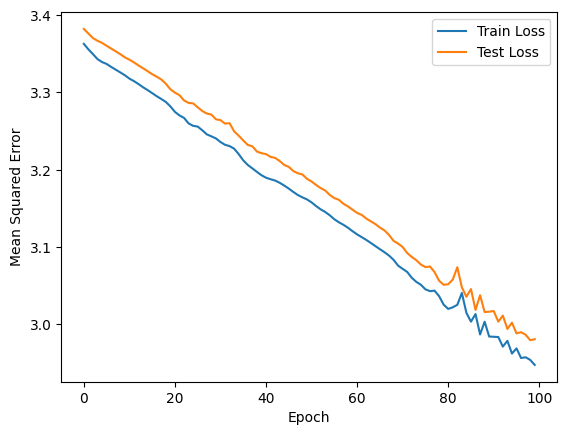

In [43]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


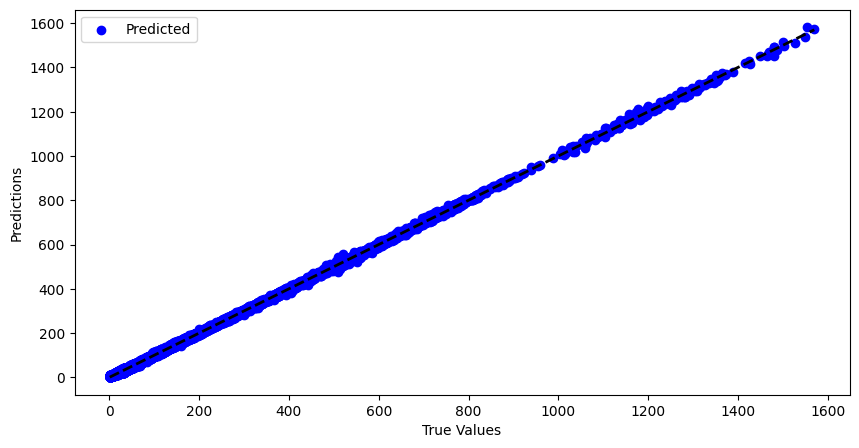

In [44]:
# Prédictions sur l'ensemble de test
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, color='blue', label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()